Iter 0, Loss: 0.8903602957725525, Lambda1: 2.068745516226045e-06, Lambda2: 0.0008412259048782289
Iter 10, Loss: 0.8588452339172363, Lambda1: 0.00010732394002843648, Lambda2: 0.010142195038497448
Iter 20, Loss: 0.7289875149726868, Lambda1: 0.004481886513531208, Lambda2: 0.009060647338628769
Iter 30, Loss: 0.4863862991333008, Lambda1: 0.014842895790934563, Lambda2: -0.00036586823989637196
Iter 40, Loss: 0.4194187521934509, Lambda1: 0.022517342120409012, Lambda2: 0.0010931272991001606
Iter 50, Loss: 0.35891979932785034, Lambda1: 0.03309433162212372, Lambda2: 0.0030162420589476824
Iter 60, Loss: 0.30988189578056335, Lambda1: 0.027004823088645935, Lambda2: 0.002301824279129505
Iter 70, Loss: 0.27185073494911194, Lambda1: 0.010405455715954304, Lambda2: 0.005137650761753321
Iter 80, Loss: 0.2415899783372879, Lambda1: -0.006848186254501343, Lambda2: 0.007238407153636217
Iter 90, Loss: 0.21891051530838013, Lambda1: -0.01861678808927536, Lambda2: 0.00947895459830761
Iter 100, Loss: 0.20040716230

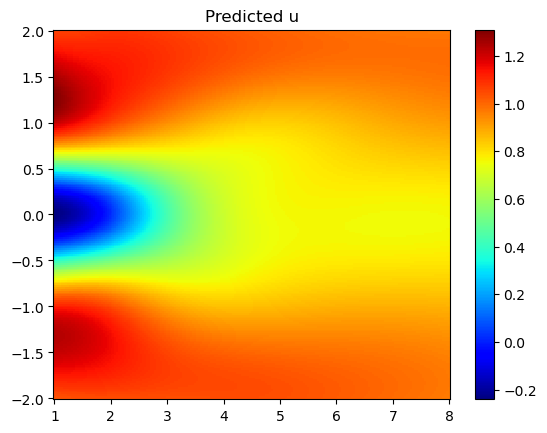

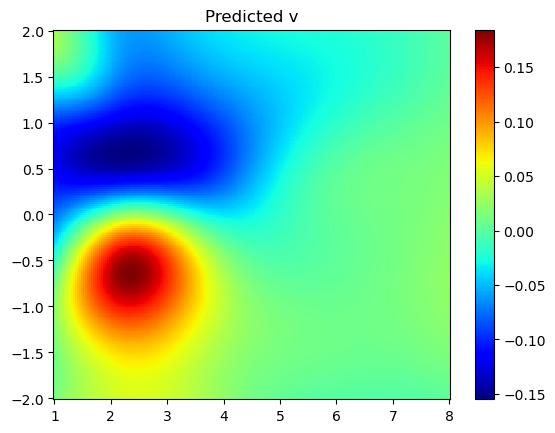

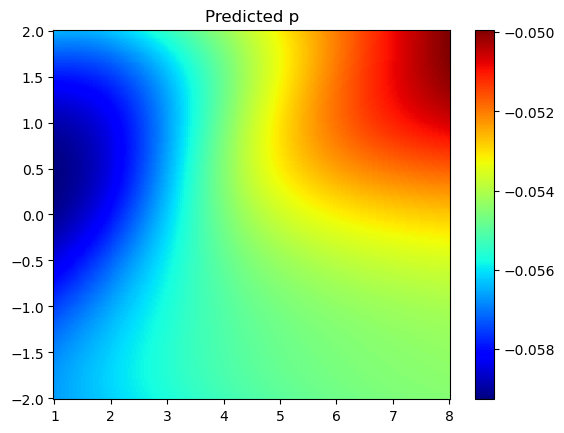

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.io
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from itertools import product, combinations

class PhysicsInformedNN:
    def __init__(self, x, y, t, u, v, layers):

        X = np.concatenate([x.detach().numpy(), y.detach().numpy(), t.detach().numpy()], axis=1)
        
        self.lb = torch.tensor(X.min(axis=0), dtype=torch.float32)
        self.ub = torch.tensor(X.max(axis=0), dtype=torch.float32)

        self.X = torch.tensor(X, dtype=torch.float32, requires_grad=True)
        self.x = self.X[:, 0:1]
        self.y = self.X[:, 1:2]
        self.t = self.X[:, 2:3]

        self.u = u
        self.v = v

        self.layers = layers
        self.model = self.build_model(layers)
        
        self.lambda_1 = nn.Parameter(torch.tensor([0.0], dtype=torch.float32))
        self.lambda_2 = nn.Parameter(torch.tensor([0.0], dtype=torch.float32))
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.optimizer_lambda = optim.Adam([self.lambda_1, self.lambda_2], lr=1e-3)

    def build_model(self, layers):
        model = []
        for i in range(len(layers) - 1):
            model.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                model.append(nn.Tanh())
        return nn.Sequential(*model)

    def forward(self, x, y, t):
        inputs = torch.cat([x, y, t], dim=1)
        inputs = 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0
        return self.model(inputs)

    def net_NS(self, x, y, t):
        psi_and_p = self.forward(x, y, t)
        psi = psi_and_p[:, 0:1]
        p = psi_and_p[:, 1:2]

        u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
        v = -torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]

        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        f_u = u_t + self.lambda_1 * (u * u_x + v * u_y) + p_x - self.lambda_2 * (u_xx + u_yy)
        f_v = v_t + self.lambda_1 * (u * v_x + v * v_y) + p_y - self.lambda_2 * (v_xx + v_yy)

        return u, v, p, f_u, f_v

    def loss_function(self, x, y, t, u, v):
        u_pred, v_pred, p_pred, f_u_pred, f_v_pred = self.net_NS(x, y, t)
        
        loss = torch.mean((u - u_pred) ** 2) + \
               torch.mean((v - v_pred) ** 2) + \
               torch.mean(f_u_pred ** 2) + \
               torch.mean(f_v_pred ** 2)
        return loss

    def train(self, n_iter):
        for it in range(n_iter):
            self.optimizer.zero_grad()
            self.optimizer_lambda.zero_grad()

            loss = self.loss_function(self.x, self.y, self.t, self.u, self.v)

            loss.backward()
            self.optimizer.step()
            self.optimizer_lambda.step()

            if it % 10 == 0:
                print(f"Iter {it}, Loss: {loss.item()}, Lambda1: {self.lambda_1.item()}, Lambda2: {self.lambda_2.item()}")

    def predict(self, x_star, y_star, t_star):
        x_star = torch.tensor(x_star, dtype=torch.float32, requires_grad=True)
        y_star = torch.tensor(y_star, dtype=torch.float32, requires_grad=True)
        t_star = torch.tensor(t_star, dtype=torch.float32, requires_grad=True)

        u_pred, v_pred, p_pred, _, _ = self.net_NS(x_star, y_star, t_star)
        return u_pred.detach().numpy(), v_pred.detach().numpy(), p_pred.detach().numpy()

# Training data setup, loading, and visualization
if __name__ == "__main__":
    # Load data
    data = scipy.io.loadmat('cylinder_nektar_wake.mat')
    U_star = data['U_star']  # N x 2 x T
    P_star = data['p_star']  # N x T
    t_star = data['t']       # T x 1
    X_star = data['X_star']  # N x 2

    N = X_star.shape[0]
    T = t_star.shape[0]

    # Rearrange data
    XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
    YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
    TT = np.tile(t_star, (1, N)).T        # N x T

    UU = U_star[:, 0, :]  # N x T
    VV = U_star[:, 1, :]  # N x T
    PP = P_star           # N x T

    x = XX.flatten()[:, None]  # NT x 1
    y = YY.flatten()[:, None]  # NT x 1
    t = TT.flatten()[:, None]  # NT x 1

    u = UU.flatten()[:, None]  # NT x 1
    v = VV.flatten()[:, None]  # NT x 1
    p = PP.flatten()[:, None]  # NT x 1

    # Training data
    N_train = 5000
    idx = np.random.choice(len(x), N_train, replace=False)
    x_train = torch.tensor(x[idx], dtype=torch.float32, requires_grad=True)
    y_train = torch.tensor(y[idx], dtype=torch.float32, requires_grad=True)
    t_train = torch.tensor(t[idx], dtype=torch.float32, requires_grad=True)
    u_train = torch.tensor(u[idx], dtype=torch.float32)
    v_train = torch.tensor(v[idx], dtype=torch.float32)

    # Model setup
    layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
    model = PhysicsInformedNN(x_train, y_train, t_train, u_train, v_train, layers)

    # Train model
    model.train(2000)

    # Test data
    snap = np.array([100])
    x_star = X_star[:, 0:1]
    y_star = X_star[:, 1:2]
    t_star = TT[:, snap]

    u_star = U_star[:, 0, snap]
    v_star = U_star[:, 1, snap]
    p_star = P_star[:, snap]

    # Predictions
    u_pred, v_pred, p_pred = model.predict(x_star, y_star, t_star)

    # Visualization
    lb = X_star.min(axis=0)
    ub = X_star.max(axis=0)
    nn = 200
    x = np.linspace(lb[0], ub[0], nn)
    y = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x, y)

    U_pred = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
    V_pred = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')
    P_pred = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')

    plt.figure()
    plt.pcolor(X, Y, U_pred, cmap='jet')
    plt.colorbar()
    plt.title('Predicted u')

    plt.figure()
    plt.pcolor(X, Y, V_pred, cmap='jet')
    plt.colorbar()
    plt.title('Predicted v')

    plt.figure()
    plt.pcolor(X, Y, P_pred, cmap='jet')
    plt.colorbar()
    plt.title('Predicted p')

    plt.show()


/var/folders/36/bbyhz1612x59sr44ryqzp3580000gn/T/ipykernel_83685/2770223779.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modes = int(data_vort['modes'])
/var/folders/36/bbyhz1612x59sr44ryqzp3580000gn/T/ipykernel_83685/2770223779.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nel = int(data_vort['nel'])


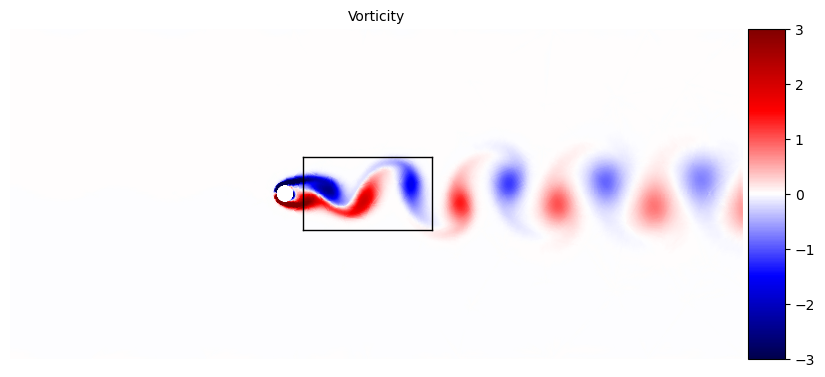

/var/folders/36/bbyhz1612x59sr44ryqzp3580000gn/T/ipykernel_83685/2770223779.py:104: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim3d(r2)
/var/folders/36/bbyhz1612x59sr44ryqzp3580000gn/T/ipykernel_83685/2770223779.py:122: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim3d(r2)


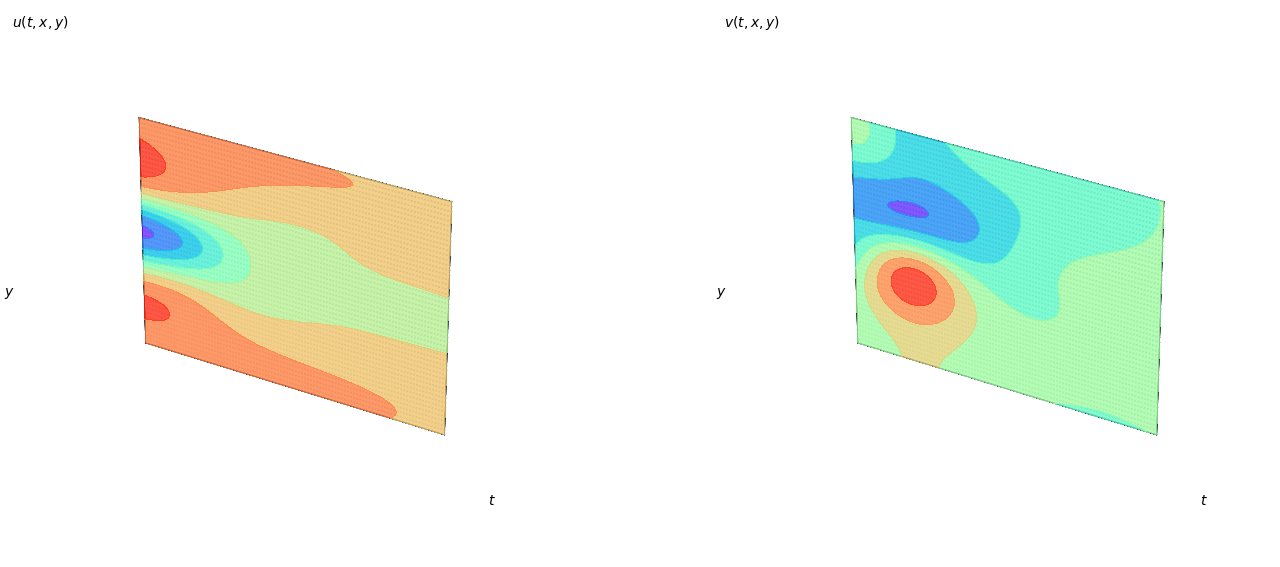

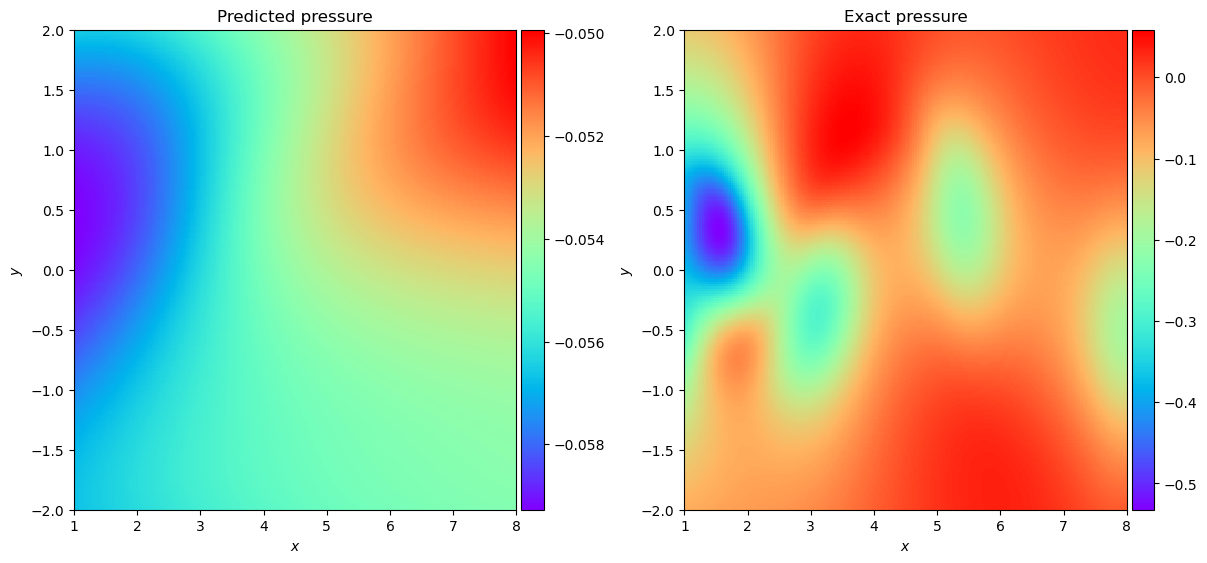

In [50]:
# Load vorticity data
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from itertools import product, combinations
from scipy.interpolate import griddata

# Load vorticity data
data_vort = scipy.io.loadmat('cylinder_nektar_t0_vorticity.mat')

data = scipy.io.loadmat('cylinder_nektar_wake.mat')
U_star = data['U_star']  # N x 2 x T
P_star = data['p_star']  # N x T
t_star = data['t']  # T x 1
X_star = data['X_star']  # N x 2
TT = np.tile(t_star, (1, X_star.shape[0])).T  # Match the shape of X_star

x_vort = data_vort['x'] 
y_vort = data_vort['y'] 
w_vort = data_vort['w'] 
modes = int(data_vort['modes'])
nel = int(data_vort['nel'])    

xx_vort = np.reshape(x_vort, (modes+1, modes+1, nel), order='F')
yy_vort = np.reshape(y_vort, (modes+1, modes+1, nel), order='F')
ww_vort = np.reshape(w_vort, (modes+1, modes+1, nel), order='F')

# Prepare a grid for predictions
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)
nn = 200
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x, y)

snap = np.array([100])
x_star = X_star[:, 0:1]  # Extract x coordinates
y_star = X_star[:, 1:2]  # Extract y coordinates
t_star = TT[:, snap]  # Extract corresponding time snapshot
p_star = P_star[:, snap]  # Extract pressure for the same snapshot

x_star = x_star.flatten()
y_star = y_star.flatten()
p_star = p_star.flatten()

# Make predictions
u_pred, v_pred, p_pred = model.predict(x_star[:, None], y_star[:, None], t_star.mean() * np.ones_like(x_star[:, None]))

points = np.hstack((x_star[:, None], y_star[:, None]))  # Combine x and y
UU_star = griddata(points, u_pred.flatten(), (X, Y), method='cubic')
VV_star = griddata(points, v_pred.flatten(), (X, Y), method='cubic')
PP_star = griddata(points, p_pred.flatten(), (X, Y), method='cubic')
P_exact = griddata(points, p_star, (X, Y), method='cubic')

box_lb = np.array([1.0, -2.0])
box_ub = np.array([8.0, 2.0])

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')

# Row 0: Vorticity
for i in range(nel):
    h = ax.pcolormesh(xx_vort[:, :, i], yy_vort[:, :, i], ww_vort[:, :, i], cmap='seismic', shading='gouraud', vmin=-3, vmax=3)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot([box_lb[0], box_lb[0]], [box_lb[1], box_ub[1]], 'k', linewidth=1)
ax.plot([box_ub[0], box_ub[0]], [box_lb[1], box_ub[1]], 'k', linewidth=1)
ax.plot([box_lb[0], box_ub[0]], [box_lb[1], box_lb[1]], 'k', linewidth=1)
ax.plot([box_lb[0], box_ub[0]], [box_ub[1], box_ub[1]], 'k', linewidth=1)

ax.set_aspect('equal', 'box')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Vorticity', fontsize=10)
plt.show()

# Row 1: Training data
fig = plt.figure(figsize=(14, 7))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=0.9, bottom=0.1, left=0.05, right=0.95, wspace=0.3)

# u(t,x,y) plot
ax = fig.add_subplot(gs1[0], projection='3d')
ax.axis('off')
r1 = [x_star.min(), x_star.max()]
r2 = [t_star.min(), t_star.max()]
r3 = [y_star.min(), y_star.max()]

for s, e in combinations(np.array(list(product(r1, r2, r3))), 2):
    if np.sum(np.abs(s - e)) in [r1[1] - r1[0], r2[1] - r2[0], r3[1] - r3[0]]:
        ax.plot3D(*zip(s, e), color="k", linewidth=0.5)

ax.scatter(x_star, t_star.mean(), y_star, s=0.1)
ax.contourf(X, UU_star, Y, zdir='y', offset=t_star.mean(), cmap='rainbow', alpha=0.8)
ax.text(x_star.mean(), t_star.min() - 1, y_star.min() - 1, '$x$')
ax.text(x_star.max() + 1, t_star.mean(), y_star.min() - 1, '$t$')
ax.text(x_star.min() - 1, t_star.min() - 0.5, y_star.mean(), '$y$')
ax.text(x_star.min() - 3, t_star.mean(), y_star.max() + 1, '$u(t,x,y)$')
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)

# v(t,x,y) plot
ax = fig.add_subplot(gs1[1], projection='3d')
ax.axis('off')

for s, e in combinations(np.array(list(product(r1, r2, r3))), 2):
    if np.sum(np.abs(s - e)) in [r1[1] - r1[0], r2[1] - r2[0], r3[1] - r3[0]]:
        ax.plot3D(*zip(s, e), color="k", linewidth=0.5)

ax.scatter(x_star, t_star.mean(), y_star, s=0.1)
ax.contourf(X, VV_star, Y, zdir='y', offset=t_star.mean(), cmap='rainbow', alpha=0.8)
ax.text(x_star.mean(), t_star.min() - 1, y_star.min() - 1, '$x$')
ax.text(x_star.max() + 1, t_star.mean(), y_star.min() - 1, '$t$')
ax.text(x_star.min() - 1, t_star.min() - 0.5, y_star.mean(), '$y$')
ax.text(x_star.min() - 3, t_star.mean(), y_star.max() + 1, '$v(t,x,y)$')
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)

plt.show()

# Row 2: Pressure plots
fig = plt.figure(figsize=(12, 6))
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=0.9, bottom=0.1, left=0.05, right=0.95, wspace=0.3)

# Predicted pressure
ax = fig.add_subplot(gs2[0])
h = ax.imshow(PP_star, interpolation='nearest', cmap='rainbow', 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Predicted pressure')

# Exact pressure
ax = fig.add_subplot(gs2[1])
h = ax.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Exact pressure')

plt.show()
